<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/Reddit_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install praw pandas

In [43]:
from google.colab import userdata
import praw
import time
import pandas as pd

In [44]:
CLIENT_ID = userdata.get("REDDIT_CLIENT_ID")
CLIENT_SECRET = userdata.get("REDDIT_CLIENT_SECRET")
USER_AGENT = userdata.get("REDDIT_USER_AGENT")

In [45]:
try:
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    print("PRAW connection successful. Operating in read-only mode.")
except Exception as e:
    print(f"An error occurred during PRAW initialization: {e}")
    reddit = None

PRAW connection successful. Operating in read-only mode.


In [62]:
def get_subreddit_data(subreddit_name, limit=500):
    """Fetches the top 'limit' posts from a subreddit for all time."""

    if reddit is None:
        return []

    subreddit = reddit.subreddit(subreddit_name)
    print(f"\nFetching top {limit} posts from r/{subreddit_name}...")

    posts_data = []

    # Fetch top posts of all time
    for submission in subreddit.top(time_filter='all', limit=limit):
        posts_data.append({
            'id': submission.id,
            'subreddit': subreddit_name,
            'title': submission.title,
            'score': submission.score,
            'num_comments': submission.num_comments,
            'author': str(submission.author), # Converts Author object to string username
            'url': submission.url,
            'created_utc': submission.created_utc,
            'is_self_post': submission.is_self
        })

    print(f"Extraction complete. Found {len(posts_data)} posts.")
    return posts_data

In [63]:
# --- 4. RUN ANALYSIS FOR FOOD TRENDS ---
if __name__ == "__main__":

    # Define the subreddits related to food trends
    # NOTE: I have corrected 'r/unpopularopnionr/uk_food' to two separate subs,
    # and 'r,snacks' to 'r/snacks' for PRAW to correctly parse them.
    target_subreddits = [
        'food', 'cooking', 'recipes', 'baking', 'streetfood',
        'easyrecipes', 'snacksindia', 'askUK', 'candy', 'chocolate',
        'UAE', 'seriouseats', 'RecipeInspiration', 'unpopularopinion',
        'uk_food', 'cookingtonight', 'pasta', 'foodhack', 'nutrition',
        'vegetarianrecipes', 'foodvideos', 'budgetcooking', 'dessertporn',
        'junkfoodfinds', 'popculturechat', 'tea', 'shittyfoodporn',
        'snacks', 'foodlosangeles', 'stupidfood', 'TikTokTrends',
        'TikTokCringe'
    ]

    all_data = []

    # Fetch data for all target subreddits
    for sub in target_subreddits:
        posts = get_subreddit_data(sub, limit=500) # Get 500 top posts per sub
        all_data.extend(posts)

    # Convert the list of dictionaries into a DataFrame for analysis
    df = pd.DataFrame(all_data)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Fetching top 500 posts from r/food...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/cooking...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/recipes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/baking...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/streetfood...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/easyrecipes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/snacksindia...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/askUK...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/candy...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/chocolate...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/UAE...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/seriouseats...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/RecipeInspiration...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 248 posts.

Fetching top 500 posts from r/unpopularopinion...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 246 posts.

Fetching top 500 posts from r/uk_food...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/cookingtonight...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 251 posts.

Fetching top 500 posts from r/pasta...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 251 posts.

Fetching top 500 posts from r/foodhack...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/nutrition...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/vegetarianrecipes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/foodvideos...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/budgetcooking...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/dessertporn...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/junkfoodfinds...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/popculturechat...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/tea...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/shittyfoodporn...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/snacks...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/foodlosangeles...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/stupidfood...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/TikTokTrends...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 122 posts.

Fetching top 500 posts from r/TikTokCringe...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.


In [64]:
df['date'] = pd.to_datetime(df['created_utc'], unit='s')
df = df.sort_values(by='date', ascending=False) # Sort newest first

print("\n--- Initial Data Check (Top 5 Rows) ---")
print(df[['subreddit', 'title', 'score', 'num_comments', 'date']].head())


--- Initial Data Check (Top 5 Rows) ---
         subreddit                                              title  score  \
1669   snacksindia                Had Maharaja Mac for the first time    243   
3539       uk_food   found a banging roast dinner in a pub in bangkok   2471   
7676  TikTokCringe  People come together to stop a man who was cau...  62367   
1547   snacksindia             Davidoff ruined other coffees for me 😭    741   
1595   snacksindia                  My friend’s wife gifted me this 😌    403   

      num_comments                date  
1669            45 2025-10-15 14:55:02  
3539           149 2025-10-14 19:00:06  
7676          1749 2025-10-14 17:02:28  
1547           213 2025-10-14 06:56:00  
1595            93 2025-10-14 03:39:42  


In [65]:
# Save the data to Google Drive (you'll need to mount drive in a separate cell if you want to save permanently)
    # df.to_csv('reddit_food_trend_data.csv', index=False)
print(f"\nSuccessfully collected {len(df)} total posts. Ready for analysis.")


Successfully collected 7861 total posts. Ready for analysis.


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7861 entries, 1669 to 1249
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            7861 non-null   object        
 1   subreddit     7861 non-null   object        
 2   title         7861 non-null   object        
 3   score         7861 non-null   int64         
 4   num_comments  7861 non-null   int64         
 5   author        7861 non-null   object        
 6   url           7861 non-null   object        
 7   created_utc   7861 non-null   float64       
 8   is_self_post  7861 non-null   bool          
 9   date          7861 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 621.8+ KB
None


In [68]:
print(df.isnull().sum())

id              0
subreddit       0
title           0
score           0
num_comments    0
author          0
url             0
created_utc     0
is_self_post    0
date            0
dtype: int64


In [69]:
print(df.describe())

               score  num_comments   created_utc  \
count    7861.000000   7861.000000  7.861000e+03   
mean     9111.410889    554.741890  1.664118e+09   
min         0.000000      0.000000  1.319216e+09   
25%       288.000000     15.000000  1.607332e+09   
50%       935.000000     75.000000  1.664039e+09   
75%      6766.000000    488.000000  1.735330e+09   
max    156258.000000  24376.000000  1.760540e+09   
std     16995.164372   1202.506641  7.345691e+07   

                                date  
count                           7861  
mean   2022-09-25 15:07:43.833227520  
min              2011-10-21 16:50:46  
25%              2020-12-07 09:01:01  
50%              2022-09-24 16:59:09  
75%              2024-12-27 19:58:25  
max              2025-10-15 14:55:02  
std                              NaN  


In [70]:
print(df.head())

           id     subreddit  \
1669  1o7d8f4   snacksindia   
3539  1o6oeke       uk_food   
7676  1o6l6yg  TikTokCringe   
1547  1o68hb2   snacksindia   
1595  1o652qi   snacksindia   

                                                  title  score  num_comments  \
1669                Had Maharaja Mac for the first time    243            45   
3539   found a banging roast dinner in a pub in bangkok   2471           149   
7676  People come together to stop a man who was cau...  62367          1749   
1547             Davidoff ruined other coffees for me 😭    741           213   
1595                  My friend’s wife gifted me this 😌    403            93   

                  author                                   url   created_utc  \
1669      sourav_agrawal  https://i.redd.it/tv2n36vlhavf1.jpeg  1.760540e+09   
3539            zereshk0  https://i.redd.it/jcbdkzxek4vf1.jpeg  1.760468e+09   
7676      Justin_Godfrey       https://v.redd.it/eeugo5qfz3vf1  1.760461e+09   
1547     Hum

<Axes: ylabel='subreddit'>

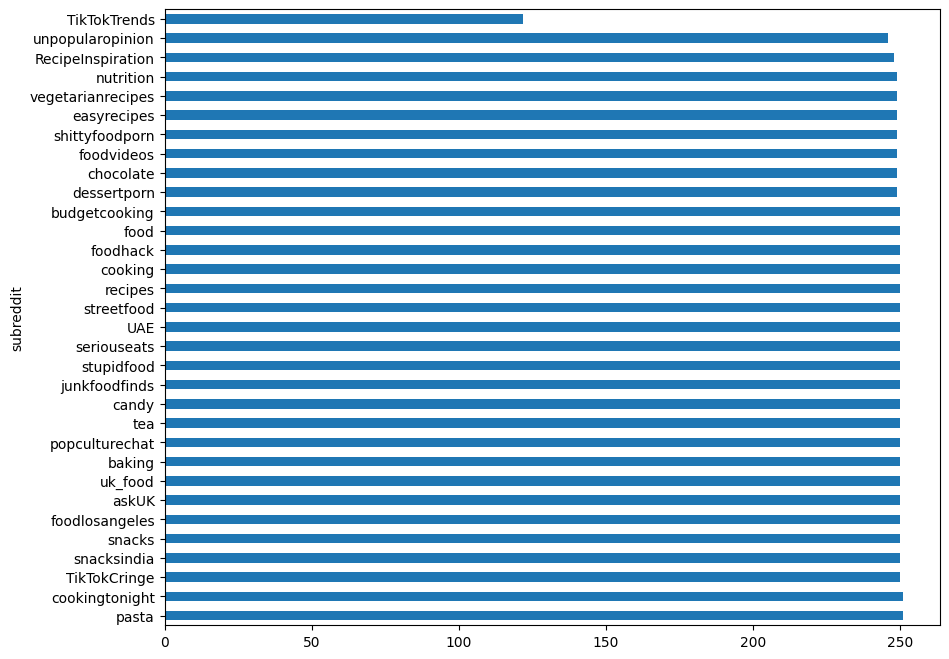

In [71]:
df['subreddit'].value_counts().plot(kind='barh', figsize=(10,8)) #which subreddits contributed the most

<Axes: >

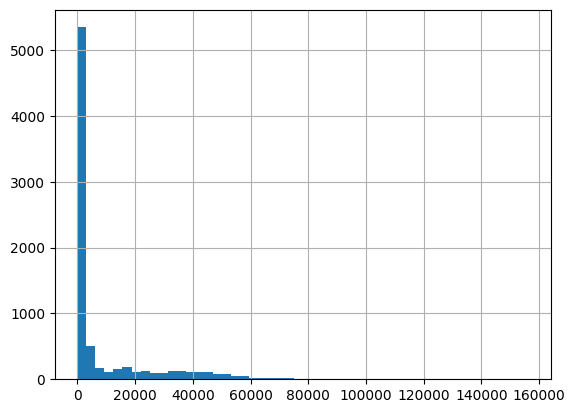

In [72]:
df['score'].hist(bins=50)

**Trend Analysis**

/tmp/ipython-input-2015624115.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('date').resample('M').size().plot() #how volume of top posts has changed over the years


<Axes: xlabel='date'>

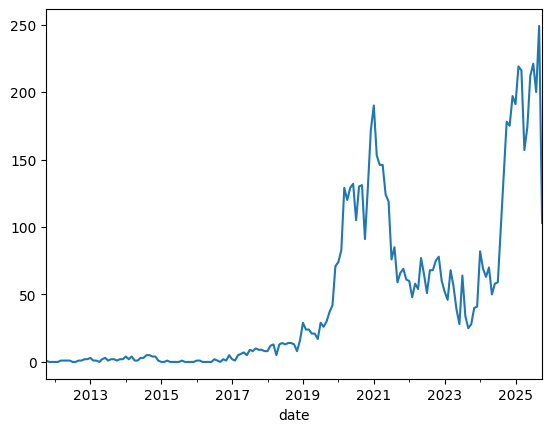

In [73]:
df.set_index('date').resample('M').size().plot() #how volume of top posts has changed over the years

/tmp/ipython-input-3937014089.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  air_fryer.set_index('date').resample('Y').size().plot(title='Air Fryer Mentions Over Time')


<Axes: title={'center': 'Air Fryer Mentions Over Time'}, xlabel='date'>

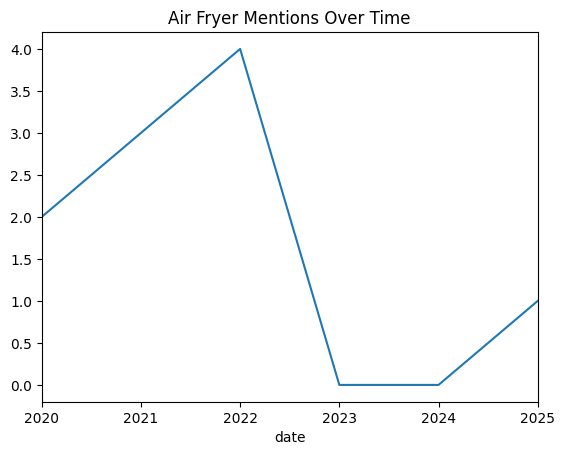

In [74]:
air_fryer = df[df['title'].str.contains('air fryer', case=False, na=False)]
air_fryer.set_index('date').resample('Y').size().plot(title='Air Fryer Mentions Over Time')

/tmp/ipython-input-1465167850.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  feta.set_index('date').resample('Y').size().plot(title='Feta Cheese Mentions Over Time')


<Axes: title={'center': 'Feta Cheese Mentions Over Time'}, xlabel='date'>

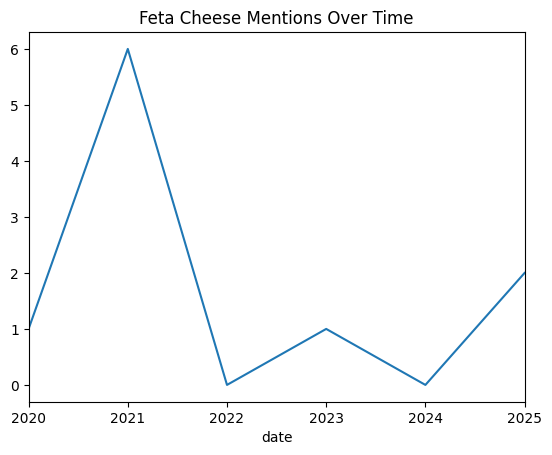

In [75]:
feta = df[df['title'].str.contains('feta', case=False, na=False)]
feta.set_index('date').resample('Y').size().plot(title='Feta Cheese Mentions Over Time')

/tmp/ipython-input-1921045851.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dubai.set_index('date').resample('Y').size().plot(title='Dubai Chocolate Mentions Over Time')


<Axes: title={'center': 'Dubai Chocolate Mentions Over Time'}, xlabel='date'>

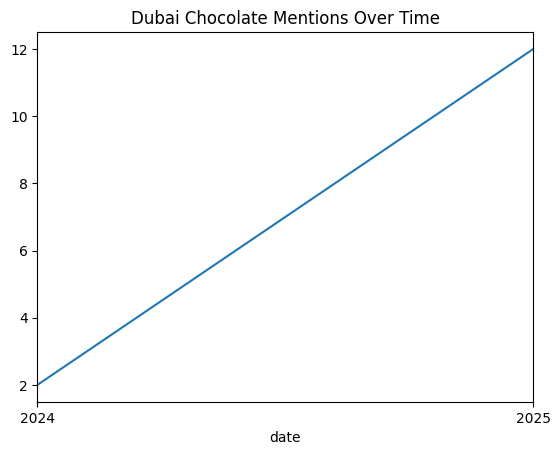

In [76]:
dubai = df[df['title'].str.contains('dubai chocolate', case=False, na=False)]
dubai.set_index('date').resample('Y').size().plot(title='Dubai Chocolate Mentions Over Time')

/tmp/ipython-input-3627766206.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  crumbl.set_index('date').resample('Y').size().plot(title='Crumbl Cookies Mentions Over Time')


<Axes: title={'center': 'Crumbl Cookies Mentions Over Time'}, xlabel='date'>

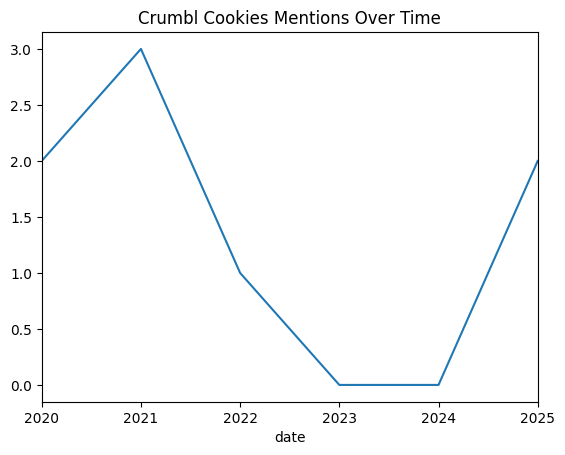

In [86]:
crumbl = df[df['title'].str.contains('crumbl', case=False, na=False)]
crumbl.set_index('date').resample('Y').size().plot(title='Crumbl Cookies Mentions Over Time')

/tmp/ipython-input-3212841451.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cottage.set_index('date').resample('Y').size().plot(title='Cottage Cheese Mentions Over Time')


<Axes: title={'center': 'Cottage Cheese Mentions Over Time'}, xlabel='date'>

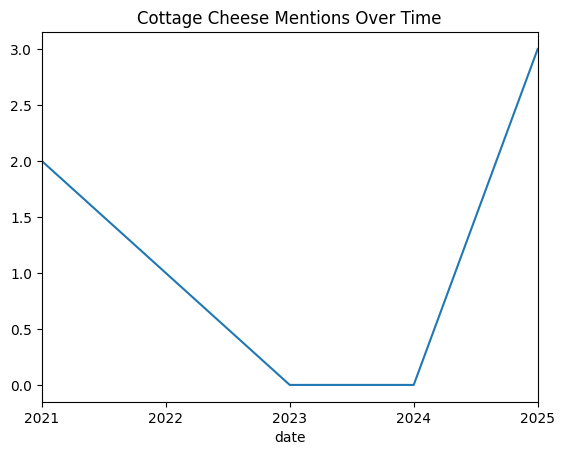

In [87]:
cottage = df[df['title'].str.contains('cottage cheese', case=False, na=False)]
cottage.set_index('date').resample('Y').size().plot(title='Cottage Cheese Mentions Over Time')

ADDING COLUMNS FOR MERGING

In [92]:
# Assuming your main DataFrame is named 'df' and already contains the 'date' column
# that was created from 'created_utc'.

# Convert the 'date' column (which may have time components) to a date-only format (YYYY-MM-DD)
df['Time_Period'] = df['date'].dt.date.astype('datetime64[ns]')

# Check the data type and format
print("--- Time_Period Column Check ---")
print(df[['date', 'Time_Period']].head())
print(f"Time_Period Data Type: {df['Time_Period'].dtype}")

--- Time_Period Column Check ---
                    date Time_Period
1669 2025-10-15 14:55:02  2025-10-15
3539 2025-10-14 19:00:06  2025-10-14
7676 2025-10-14 17:02:28  2025-10-14
1547 2025-10-14 06:56:00  2025-10-14
1595 2025-10-14 03:39:42  2025-10-14
Time_Period Data Type: datetime64[ns]
